In [2]:
import linecache as lc
import re
import matplotlib.pyplot as plt
import os

In [3]:
data_file = 'SSdata.txt'
start_year = 2018

In [4]:
def get_month(month_str):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

    return months.index(month_str) + 1

def get_hour(hour_str, am_pm_str):
    hour_int = int(hour_str)

    if ('PM' == am_pm_str) and (hour_int != 12):
        hour_int += 12

    return hour_int

In [5]:
def add_item(line_number, order_index, print_line=False):
    global data_set

    # The first line is the item description
    if print_line:
        print(line_number)
    item_desc_line = lc.getline(data_file, line_number).replace('\n', '')

    # For a gas item, this line will be 'Subtotal'
    if (lc.getline(data_file, line_number - 4).find('Gas') > -1):
        # The next line has the subtotal
        if print_line:
            print(line_number + 1)
        price_float = float(re.sub('\$|\n| \$','',lc.getline(data_file, line_number + 1)))

        # Number of points is 9 steps away
        if print_line:
            print(line_number + 9)
        num_of_points = int(lc.getline(data_file, line_number + 9).split(' ')[0])

        # Add some predefined data

        data_set['Items'][order_index].append({
            'Name' : 'Regular',
            'Code' : 'Gas',
            'Unit' : 'Liter',
            'Price per unit' : price_float / (0.03 * num_of_points),
            'Quantity' : num_of_points * 0.03,
            'Price' : price_float
        })

        there_are_more_items = False
    # Else if the next item simply says subtotal and nothing else:
    elif item_desc_line.find('Subtotal') > -1:
        data_set['Items'][order_index].append({
            'Name' : 'Unknown',
            'Code' : 'Unknown', 
            'Unit' : 'Unknown',
            'Price per unit': 'Unknown',
            'Quantity': 'Unknown',
            'Price' : float(re.sub('\$|\n| \$', '', lc.getline(data_file, line_number + 1)))
        })
        there_are_more_items = False
    else:   
        # The next line has the code and the unit type
        line_number += 1
        if print_line:
            print(line_number)
            print('{}'.format(lc.getline(data_file, line_number).replace('\n', '').split('_')))
        
        # If this line does not contain an underscore, add it to the description and move
        # to the next line
        code_line = lc.getline(data_file, line_number).replace('\n', '')
        if code_line.find('_') == -1:
            item_desc_line += ' ' + code_line
            line_number += 1

        code_str, type_str = lc.getline(data_file, line_number).replace('\n', '').split('_')
        type_str = type_str.lower()

        # The next line has the quantity and price per unit
        line_number += 1
        if print_line:
            print(line_number)
        _, qty_str, ppu_str, _ = re.sub(r'/|\n| \$|\@ |\$', '', lc.getline(data_file, line_number)).split(' ')

        # The next line has the price
        line_number += 1
        if print_line:
            print(line_number)
        price_str = re.sub(r'\$|\n| \$', '', lc.getline(data_file, line_number))

        # Check if the next line is the subtotal
        line_number += 1
        if print_line:
            print(line_number)
        there_are_more_items = False if lc.getline(data_file, line_number).find('Subtotal') > -1 else True

        # Add the item data
        data_set['Items'][order_index].append({
            'Name' : item_desc_line,
            'Code' : code_str,
            'Unit' : type_str,
            'Price per unit' : float(ppu_str),
            'Quantity' : qty_str,
            'Price' : float(price_str)
        })

    return there_are_more_items, line_number

In [6]:
def find_double_slashes(line_number):
    there_is_another_order = False
    while True:
        current_str = lc.getline(data_file, line_number)
        if current_str != '':
            if (current_str.find('Order#') > -1):
                there_is_another_order = True
                break
            else:
                line_number += 1
        else:
            print('Reached EOF')
            break
    
    return there_is_another_order, line_number


In [7]:
global current_year; current_year = start_year
global previous_month; previous_month = 1
global num_of_orders; num_of_orders = 0
global month_count; month_count = 0

data_set = {
    'Order number' : list(),
    'Date' : list(),
    'Month count': list(),
    'Location' : list(),
    'Phone number' : list(),
    'Items' : list(),
    'Subtotal' : list(),
    'Tax' : list(),
    'Total' : list(),
    'Points' : list()
}

def add_order(next_line, debug_print=False):
    global data_set
    global num_of_orders

    num_of_orders += 1
    # Must start at the order number line
    # Get the order number
    line_input = lc.getline(data_file, next_line).replace('\n', '').split(' ')
    order_number_index = line_input.index('Order#') + 1
    data_set['Order number'].append(int(line_input[order_number_index]))
    
    # Next line has the date
    next_line += 1
    date_data = re.split(r", |:|\s", re.sub("PICKED UP - |\n", "", lc.getline(data_file, next_line)))
    # The result is a list with the following structure:
    # Month, day, hour, minute, AM/PM

    # Add the month:
    current_month = get_month(date_data[0])

    # Use the month to see if the year has increased
    global current_year
    global previous_month
    global month_count
    if (previous_month > current_month):
        # If the current month is 1 and the previous month was 12, add 1 to the year
        current_year += 1

    if (previous_month != current_month):
        month_count += 1
        
    previous_month = current_month
    current_day = int(date_data[1])
    current_hour = get_hour(date_data[2], date_data[4])
    current_minute = int(date_data[3])
    data_set['Date'].append(f'{current_year}-{current_month}-{date_data[1]} {current_hour}:{current_minute}')

    data_set['Month count'].append(month_count)

    # Next line only says "Real Canadian Superstore"
    next_line += 1

    # Next line is the store
    next_line += 1
    store_text = re.sub(r'Real Canadian Superstore| -|\n', '', lc.getline(data_file, next_line))
    data_set['Location'].append(store_text)

    # Next line is the zip code
    next_line += 1

    # Next line is the phone number
    next_line += 1
    data_set['Phone number'].append(lc.getline(data_file, next_line).replace('\n', ''))

    # Next line says "SHOP AVAILABLE ITEMS" and it is the marker to start looking for items
    next_line += 1

    # Next line is an item
    next_line += 1

    there_are_more_items = True

    # Create a new item list for this order
    data_set['Items'].append(list())

    while there_are_more_items:
        there_are_more_items, next_line = add_item(next_line, num_of_orders - 1, debug_print)

    # Item parser ends at 'Subtotal'. Next line is the actual subtotal
    next_line += 1
    data_set['Subtotal'].append(float(re.sub(r'\$|\n| \$', '', lc.getline(data_file, next_line))))

    # Two lines after that there is the tax
    next_line += 2
    data_set['Tax'].append(float(re.sub(r'\$|\n| \$', '', lc.getline(data_file, next_line))))

    # Four lines after that there is the total
    next_line += 4
    data_set['Total'].append(float(re.sub(r'\$|\n| \$', '', lc.getline(data_file, next_line))))

    # If in the next two lines after that we find "points", store the points
    points_line = lc.getline(data_file, next_line + 2)
    num_of_points = 0
    if points_line.find('Points') > -1:
        num_of_points = int(points_line.split(' ')[0])
    
    data_set['Points'].append(num_of_points)

    # Find the double bars and position in the next line
    there_is_another_order, next_line = find_double_slashes(next_line)

    return there_is_another_order, next_line
        
# Run the function
current_line = 1
there_is_another_order = True

while there_is_another_order:
    there_is_another_order, current_line = add_order(current_line)

Reached EOF


In [8]:
import pandas as pd
df = pd.DataFrame(data_set)

In [9]:
df.head()

,Order number,Date,Month count,Location,Phone number,Items,Subtotal,Tax,Total,Points
0,6489,2018-2-4 17:24,1,Coquitlam,1-833-604-2787,"[{'Name': 'White Onion', 'Code': '20003839001'...",89.52,3.97,93.49,0
1,1821,2018-3-24 19:8,2,Vancouver Grandview,1-833-604-2787,[{'Name': 'Instant Oatmeal Apples & Cinnamon 1...,71.59,0.20,71.79,1800
2,558,2018-4-14 17:47,3,Vancouver Grandview,1-833-604-2787,"[{'Name': 'White Onion', 'Code': '20003839001'...",55.21,0.25,55.46,1400
3,6572,2018-4-21 17:39,3,Vancouver Grandview,1-833-604-2787,"[{'Name': 'Crustini Buns', 'Code': '20521048',...",73.13,1.84,75.75,10500
4,6864,2018-5-19 18:35,4,Vancouver Grandview,1-833-604-2787,"[{'Name': 'Hi-Chew, Green Apple', 'Code': '208...",93.40,2.07,96.25,8600


In [10]:
product_data_set = dict()

for order_i in df.index.to_list():
    for item_i in df['Items'].values[order_i]:
        if not (item_i['Name'] in product_data_set):
            product_data_set.update({item_i['Name'] : list()})
            
        product_data_set[item_i['Name']] += [
            {
                'Date': df['Date'].iat[order_i].split(' ')[0],
                'Price per unit': item_i['Price per unit'],
                'Price': item_i['Price']
            }
        ]


products = {prod_name : pd.DataFrame(prod_dict) for prod_name, prod_dict in product_data_set.items()}
list(products.keys())[0:10]


['White Onion',
 'Grade A Extra Large Eggs',
 '12” Skillet',
 'Froot Loops Cereal, Family Size',
 'Apple & Cinnamon Instant Oatmeal',
 'Pink Lady Apples',
 'Chopped Ham Cooked Sliced',
 'Decadent Chocolate Chips',
 'Cut Green Beans',
 'Accents Petite Cut Stewed Tomatoes, Garlic & Olive Oil']

In [11]:
for p, p_df in products.items():
    if p_df.shape[0] > 2:
        p_fig = p_df.plot(x='Date', y=['Price per unit', 'Price'], title=p, figsize=(16,3))
        fig = p_fig.get_figure()
        f_name = re.sub('/|%|,', '', p)
        fig.savefig(f'./grocery_csvs/all_plots/{f_name}.jpg')


/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


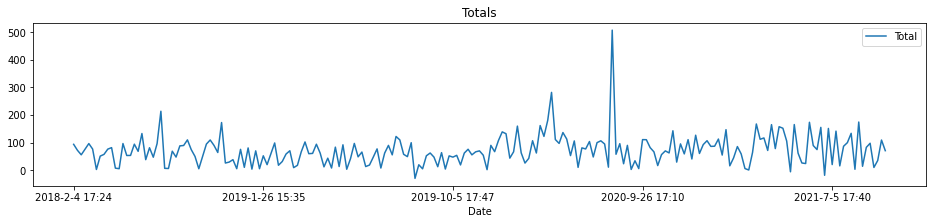

In [ ]:
df_plot = df.plot(x='Date', y='Total', figsize=(16,3))
df_plot.set_title('Totals')
fig = df_plot.get_figure()
fig.savefig('./grocery_csvs/Totals.jpg')

In [ ]:
df.loc[df['Total'].argsort()].tail()

,Order number,Date,Month count,Location,Phone number,Items,Subtotal,Tax,Total,Points
207,6044,2021-8-7 12:57,43,Coquitlam Westwood,1-833-604-2787,"[{'Name': 'White Onion', 'Code': '20003839001'...",163.56,9.53,174.41,3400
125,2323,2020-4-18 16:28,27,Vancouver Grandview,1-833-604-2787,"[{'Name': 'Chunk Light Tuna', 'Code': '2052164...",176.84,2.81,180.85,7600
23,601,2018-9-8 17:47,8,Vancouver Grandview,1-833-604-2787,"[{'Name': 'Broccoli Crowns', 'Code': '20026161...",195.44,17.12,213.60,800
126,5494,2020-5-2 18:46,28,Vancouver Grandview,1-833-604-2787,[{'Name': 'Di Toscana Mushroom Alfredo Pasta S...,269.98,11.58,282.06,18800
142,1307,2020-8-23 17:22,31,Coquitlam Westwood,1-833-604-2787,"[{'Name': '55 Inch 4K Uhd Smart TV', 'Code': '...",414.24,68.88,508.12,0


In [ ]:
expensive_data = pd.DataFrame(df.iloc[125,:]['Items'])
expensive_data

,Name,Code,Unit,Price per unit,Quantity,Price
0,Chunk Light Tuna,20521647,ea,1.18,3,3.54
1,Four Cheese Italiano Cheese Shreds,20866813005,ea,5.97,1,5.97
2,Milk Chocolate Chipits Chips,20322910001,ea,3.28,1,3.28
3,Hot Dog Buns,21192729,ea,3.48,1,3.48
4,Coconut Unsweetened Beverage,20556071001,ea,2.98,1,2.98
5,Root Beer (Case),20316407001,c12,4.98,c12,4.98
6,Anjou Pears,20174514001,kg,4.37,1.3kg,5.68
7,Penne Rigate,20721045002,ea,1.98,1,1.98
8,White Onion,20003839001,kg,4.37,1.62kg,7.08
9,"Sweet Buff Up, Sugar Scrub",21177469,ea,8.99,1,8.99


In [ ]:
df['Points'].sum()

464250

In [ ]:
df.Total.mean()

71.51293023255815

In [ ]:
df['Tax'].sum()

465.06

In [ ]:
dd = 3
months_x = list()
mean_totals = list()
start_date = re.split("-", df.Date.iat[0]) # Get the first date

def get_date_by_month_offset(start_date, month_offset):
    months =  int(start_date[1]) + month_offset
    new_month = 12 if months % 12 == 0 else months % 12

    new_year = int(start_date[0]) + int(month_offset / 12)

    return f'{new_year}-{new_month}'

for k in range(dd, 43, dd):
    months_x.append(get_date_by_month_offset(start_date, k))
    mean_totals.append(df[(df['Month count'] > k) & (df['Month count'] <= (k+dd))].Total.mean())
    
plt.figure(figsize=(16,4))
plt.plot(months_x, mean_totals, '*-')
plt.title(f"{dd}-month averages")
plt.savefig('./grocery_csvs/three_month_avg.jpg')

In [ ]:
df['Total'].sum()/month_count

357.5646511627907

In [ ]:
df.iloc[0]

Order number                                                 6489
Date                                               2018-2-4 17:24
Month count                                                     1
Location                                                Coquitlam
Phone number                                       1-833-604-2787
Items           [{'Name': 'White Onion', 'Code': '20003839001'...
Subtotal                                                    89.52
Tax                                                          3.97
Total                                                       93.49
Points                                                          0
Name: 0, dtype: object

In [ ]:
list(products.keys())[:60]

['White Onion',
 'Grade A Extra Large Eggs',
 '12” Skillet',
 'Froot Loops Cereal, Family Size',
 'Apple & Cinnamon Instant Oatmeal',
 'Pink Lady Apples',
 'Chopped Ham Cooked Sliced',
 'Decadent Chocolate Chips',
 'Cut Green Beans',
 'Accents Petite Cut Stewed Tomatoes, Garlic & Olive Oil',
 'Herb & Garlic Natural Shredded Cheese',
 'Parsley Flakes',
 'Carrots 2 LB',
 'Herbal Cough Mixture',
 'Peaches & Cream Instant Oatmeal',
 'Milk, 2%',
 'Broccoli Crowns',
 'Basil Leaves',
 'Instant Oatmeal Apples & Cinnamon 10 Instant Oatmeal Packets',
 'Large Original Tortillas',
 'Cinnamon Cake Donuts',
 'Giuseppe Rising Crust Pizza, Canadian',
 'Red Seedless Grapes',
 'Di Toscana Roasted Portobello Mushrooms',
 'Assorted Sizes Cut Green Beans',
 'Instant Oatmeal Peaches & Cream 10 Packets',
 'Nestlé Nesquik Cereal Family Size',
 'Nutri Total Meal Replacement, Vanilla (Case)',
 'Guava',
 'Greenhouse Peppers, Orange',
 'Giuseppe Hawaiian Rising Crust Pizza',
 'Margarine with Olive Oil',
 'Strawbe

<AxesSubplot:title={'center':'Gunny Cola Bottles, Sour (n=1)'}, xlabel='Date'>

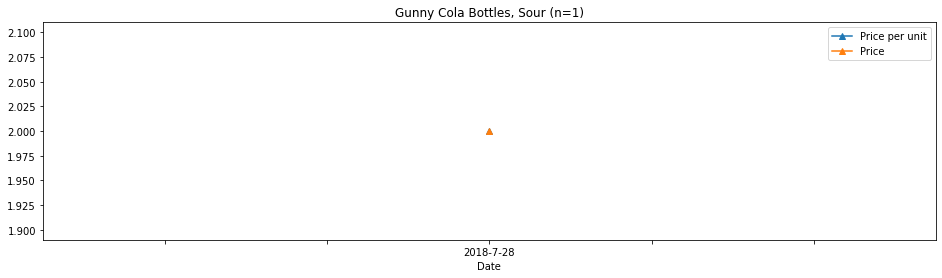

In [ ]:
prod_title=list(products.keys())[158]
products[prod_title].plot(x='Date', y=['Price per unit', 'Price'], title=f'{prod_title} (n={products[prod_title].shape[0]})', figsize=(16,4), marker='^')

In [ ]:
purchase_history = dict()
purchase_history['Date'] = []
for order_i in df.index.to_list():
    purchase_history['Date'] += df.Date.iloc[order_i]
    for item_i in df['Items'].values[order_i]:
        if not (item_i['Name'] in purchase_history.keys()):
            purchase_history.update({item_i['Name'] : list()})
            
        purchase_history[item_i['Name']] += [item_i['Price']]


len(purchase_history['White Onion'])

85

In [ ]:
re.split("-", df.Date.iat[0])

['2018', '2', '4 17:24']

In [ ]:
with pd.ExcelWriter('./grocery_csvs/groceries.xlsx') as writer:
    df[['Date', 'Subtotal', 'Tax', 'Total', 'Points']].to_excel(writer, sheet_name='Trip totals')
    for p, p_df in products.items():
        if p_df.shape[0] > 1:
            f_name = re.sub(r' /', '_', p)
            f_name = re.sub(r',', '', f_name)
            f_name = re.sub(r'%', 'perc', f_name)
            # p_df.to_csv(f'./grocery_csvs/{f_name[:30]}.csv')
            p_df.to_excel(writer, sheet_name=f_name)
    
